In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/archive/"

In [ ]:
import os

data_dirs = ["/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/archive/AiArtData", "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/archive/RealArt"]
total_count = 0

for data_dir in data_dirs:
    dir_name = os.path.basename(data_dir)
    files_count = 0
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            files_count += len(os.listdir(folder_path))
    print(f"Folder '{folder_name}' contains {files_count} images.")
    total_count += files_count

print(f"\nTotal number of images in the dataset: {total_count}")

Folder 'AiArtData' contains 539 images.
Folder 'RealArt' contains 436 images.

Total number of images in the dataset: 975


**Splitting the dataset into Training data and Testing data**

In [ ]:
import os
import cv2
from sklearn.model_selection import train_test_split
import shutil

# Define paths for the dataset directories
data_root = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/archive"
training_data_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/training_data"
testing_data_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/testing_data"

# Ensure the training and testing directories are created if they don't exist
os.makedirs(training_data_path, exist_ok=True)
os.makedirs(testing_data_path, exist_ok=True)

# Check if data has already been split into training and testing sets
training_data_exists = len(os.listdir(training_data_path)) > 0
testing_data_exists = len(os.listdir(testing_data_path)) > 0

if not (training_data_exists and testing_data_exists):
    # Initialize lists to store image file paths and their respective labels
    image_paths = []
    categories = []

    # Traverse the dataset directory structure
    for class_name in os.listdir(data_root):
        class_path = os.path.join(data_root, class_name)
        if os.path.isdir(class_path):
            for subclass in os.listdir(class_path):
                subclass_path = os.path.join(class_path, subclass)
                if os.path.isdir(subclass_path):
                    for image_file in os.listdir(subclass_path):
                        image_paths.append(os.path.join(subclass_path, image_file))
                        categories.append(class_name)

    # Split the dataset into training and testing subsets
    train_images, test_images, train_categories, test_categories = train_test_split(
        image_paths, categories, test_size=0.2, random_state=42
    )

    # Display the number of images in each subset
    print(f"Number of training images: {len(train_images)}")
    print(f"Number of testing images: {len(test_images)}")

    # Copy files to training directory if empty
    if not training_data_exists:
        for img, category in zip(train_images, train_categories):
            target_training_dir = os.path.join(training_data_path, category)
            os.makedirs(target_training_dir, exist_ok=True)
            shutil.copy(img, os.path.join(target_training_dir, os.path.basename(img)))

    # Copy files to testing directory if empty
    if not testing_data_exists:
        for img, category in zip(test_images, test_categories):
            target_testing_dir = os.path.join(testing_data_path, category)
            os.makedirs(target_testing_dir, exist_ok=True)
            shutil.copy(img, os.path.join(target_testing_dir, os.path.basename(img)))

    print("Dataset has been successfully split into training and testing sets.")
else:
    print("Training and testing datasets are already prepared.")


Number of training images: 780
Number of testing images: 195
Dataset has been successfully split into training and testing sets.


**Image Data Preprocessing and Augmentation for Deep Learning Models**

In [7]:
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to directories for training and testing datasets
training_data_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/training_data"
testing_data_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/testing_data"
batch_size_images = 32

# Augmentation and normalization configuration for training images
training_augmentor = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to the range [0, 1]
    rotation_range=15,  # Allow random rotations up to 15 degrees
    width_shift_range=0.1,  # Shift the width of images randomly up to 10%
    height_shift_range=0.1,  # Shift the height of images randomly up to 10%
    shear_range=0.1,  # Apply random shearing transformations
    zoom_range=0.1,  # Random zoom within the range of 10%
    horizontal_flip=True,  # Enable horizontal flipping of images
    fill_mode='nearest'  # Fill in pixels using nearest neighbor interpolation
)

# Normalization configuration for testing images (no augmentations applied)
testing_normalizer = ImageDataGenerator(rescale=1./255)

# Generate training batches using the training augmentor
training_image_generator = training_augmentor.flow_from_directory(
    training_data_path,
    target_size=(224, 224),  # Resize images to 224x224 resolution
    batch_size=batch_size_images,
    class_mode='categorical',  # Use categorical encoding for labels
    color_mode='rgb',  # Process images in RGB format
    interpolation='bilinear',  # Use bilinear interpolation for resizing
    follow_links=True  # Follow symbolic links in directories if present
)

# Generate testing batches using the testing normalizer
testing_image_generator = testing_normalizer.flow_from_directory(
    testing_data_path,
    target_size=(224, 224),  # Resize images to 224x224 resolution
    batch_size=batch_size_images,
    class_mode='categorical',  # Use categorical encoding for labels
    color_mode='rgb',  # Process images in RGB format
    interpolation='bilinear',  # Use bilinear interpolation for resizing
    follow_links=True,  # Follow symbolic links in directories if present
    shuffle=False  # Keep the testing data order consistent
)


Found 776 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


**Visualizing AI-Generated and Real Images**

Displaying Sample Images from Dataset:


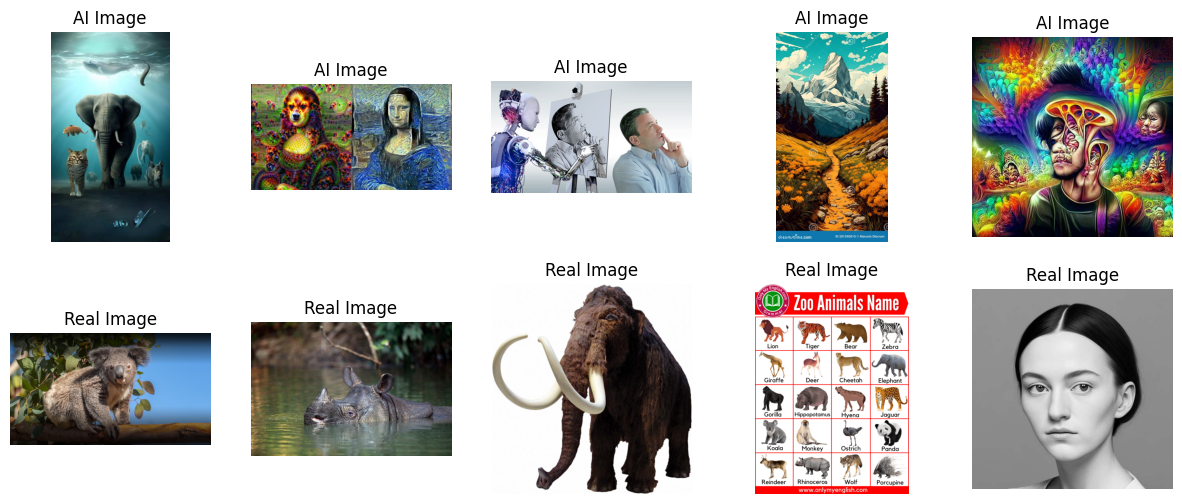

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to directories containing AI-generated and real images
ai_generated_images_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/training_data/AiArtData"
real_images_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/training_data/RealArt"

# Function to display a sample of AI-generated and real images
def display_image_samples(ai_dir, real_dir, sample_count=5):
    print("Displaying Sample Images from Dataset:")
    # Create a grid for visualizing images
    fig, axes = plt.subplots(2, sample_count, figsize=(15, 6))

    # Load and display AI-generated images
    for idx, image_name in enumerate(os.listdir(ai_dir)[:sample_count]):
        image_full_path = os.path.join(ai_dir, image_name)
        image_data = cv2.imread(image_full_path)
        axes[0, idx].imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
        axes[0, idx].axis('off')  # Hide axis lines for clarity
        axes[0, idx].set_title('AI Image')

    # Load and display real images
    for idx, image_name in enumerate(os.listdir(real_dir)[:sample_count]):
        image_full_path = os.path.join(real_dir, image_name)
        image_data = cv2.imread(image_full_path)
        axes[1, idx].imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
        axes[1, idx].axis('off')  # Hide axis lines for clarity
        axes[1, idx].set_title('Real Image')

    # Display the grid of images
    plt.show()

# Call the function to visualize samples from the dataset
display_image_samples(ai_generated_images_path, real_images_path)


**CNN Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the number of output classes and input shape
num_classes = 2
input_shape = (224, 224, 3)

# Function to build the CNN model
def create_cnn_model():
    model = models.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the CNN model
cnn_model = create_cnn_model()

cnn_model.summary()
# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    metrics=['accuracy']  # Monitor accuracy during training
)

# Define the path to save the best model
model_checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/cnn_model.keras"

# Define callbacks for model saving and early stopping
checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = cnn_model.fit(
    training_image_generator,
    epochs=30,
    validation_data=testing_image_generator,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,050 (98.37 MB)

 Trainable params: 25,785,090 (98.36 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/25 ━━━━━━━━━━━━━━━━━━━━ 2:13 8s/step - accuracy: 0.4628 - loss: 2.3999

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5284 - loss: 1.9925
Epoch 1: val_accuracy improved from -inf to 0.45876, saving model to /content/drive/MyDrive/Colab Notebooks/final_project-ranatej/cnn_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 314s 10s/step - accuracy: 0.5308 - loss: 1.9757 - val_accuracy: 0.4588 - val_loss: 1.6624
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.6249 - loss: 0.9513
Epoch 2: val_accuracy did not improve from 0.45876
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6245 - loss: 0.9512 - val_accuracy: 0.4381 - val_loss: 2.4189
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.6745 - loss: 0.7972
Epoch 3: val_accuracy did not improve from 0.45876
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6733 - loss: 0.7982 - val_accuracy: 0.4278 - val_loss: 1.6292
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.6731 - loss: 0.7295
Epoch 4: val_accuracy improved from 0.45876 to 0.51546, saving model to /co

In [ ]:
# Load the best model weights
cnn_model.load_weights(model_checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(testing_image_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 956ms/step - accuracy: 0.5786 - loss: 0.8531
Test Accuracy: 0.58


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 891ms/step


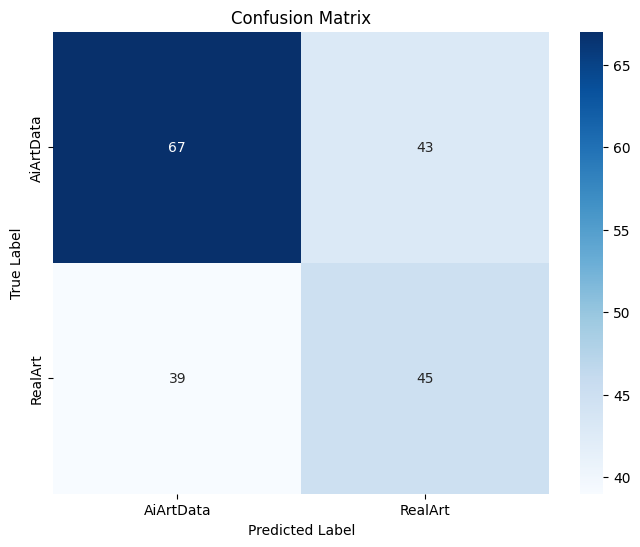

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions from the trained model on the testing data
Y_pred = cnn_model.predict(testing_image_generator)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)

# Get the true class labels from the test generator
y_true = testing_image_generator.classes

# Generate the confusion matrix to evaluate the classification performance
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=testing_image_generator.class_indices.keys(), yticklabels=testing_image_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Generate a classification report with precision, recall, and f1-score for each class
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       110
           1       0.51      0.54      0.52        84

    accuracy                           0.58       194
   macro avg       0.57      0.57      0.57       194
weighted avg       0.58      0.58      0.58       194



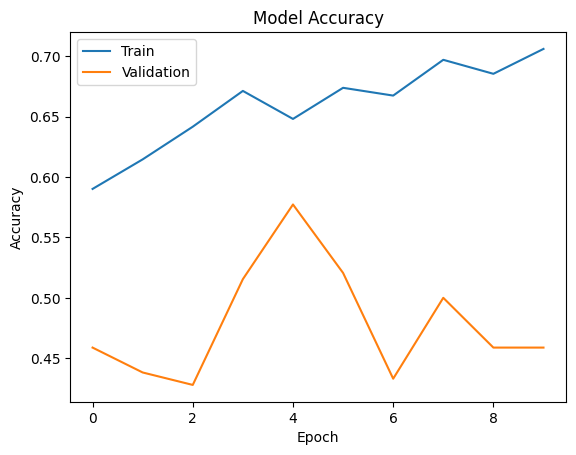

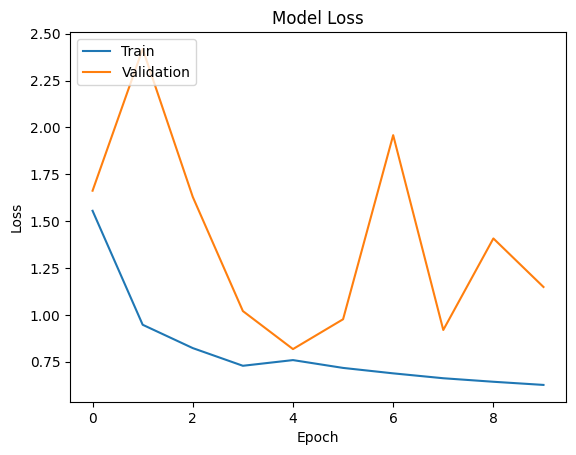

In [ ]:
import matplotlib.pyplot as plt

# Plotting the accuracy curve for both training and validation
plt.plot(history.history['accuracy'])  # Training accuracy
plt.plot(history.history['val_accuracy'])  # Validation accuracy
plt.title('Model Accuracy')  # Title of the plot
plt.ylabel('Accuracy')  # Y-axis label
plt.xlabel('Epoch')  # X-axis label
plt.legend(['Train', 'Validation'], loc='upper left')  # Legend to distinguish train and validation curves
plt.show()  # Display the plot

# Plotting the loss curve for both training and validation
plt.plot(history.history['loss'])  # Training loss
plt.plot(history.history['val_loss'])  # Validation loss
plt.title('Model Loss')  # Title of the plot
plt.ylabel('Loss')  # Y-axis label
plt.xlabel('Epoch')  # X-axis label
plt.legend(['Train', 'Validation'], loc='upper left')  # Legend to distinguish train and validation curves
plt.show()  # Display the plot


**ResNet Model**

In [8]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Define the number of output classes and input shape
num_classes = 2
input_shape = (224, 224, 3)

# Function to create the ResNet101 model with fine-tuning
def create_resnet101_model_finetuned():
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the top layers (last 10 layers)
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    model = models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())  # Global average pooling layer
    model.add(tf.keras.layers.Dense(256, activation='relu'))  # Dense layer
    model.add(tf.keras.layers.BatchNormalization())  # Batch normalization
    model.add(tf.keras.layers.Dropout(0.4))  # Dropout for regularization
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer

    return model

# Create the ResNet101 model
resnet101_model = create_resnet101_model_finetuned()
resnet101_model.summary()

# Compile the model
resnet101_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Smaller learning rate for fine-tuning
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    metrics=['accuracy']  # Monitor accuracy during training
)

# Define the path to save the best model
model_checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/final_project-ranatej/resnet101_model.keras"

# Define callbacks for model saving and early stopping
checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history_resnet101 = resnet101_model.fit(
    training_image_generator,  # Existing training image generator
    epochs=50,  # Train for 50 epochs
    validation_data=testing_image_generator,  # Existing testing image generator
    callbacks=[checkpoint_callback, early_stopping_callback]
)



171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,184,258 (164.73 MB)

 Trainable params: 43,078,402 (164.33 MB)

 Non-trainable params: 105,856 (413.50 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5507 - loss: 1.0144
Epoch 1: val_accuracy improved from -inf to 0.60309, saving model to /content/drive/MyDrive/Colab Notebooks/final_project-ranatej/resnet101_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 543s 14s/step - accuracy: 0.5513 - loss: 1.0133 - val_accuracy: 0.6031 - val_loss: 0.6828
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6557 - loss: 0.7776
Epoch 2: val_accuracy did not improve from 0.60309
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6560 - loss: 0.7763 - val_accuracy: 0.4433 - val_loss: 0.8007
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6994 - loss: 0.6694
Epoch 3: val_accuracy did not improve from 0.60309
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6998 - loss: 0.6678 - val_accuracy: 0.5773 - val_loss: 0.7791
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7417 - loss: 0.6171
Epoch 4: val_accuracy did not improve from 0.60309
25/25 ━━━━━━━━━━━━━━━━━━━━

In [9]:
# Evaluate the model
val_loss, val_accuracy = resnet101_model.evaluate(testing_image_generator)
print(f"Validation Accuracy: {val_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 994ms/step - accuracy: 0.7907 - loss: 0.6484
Validation Accuracy: 0.6030927896499634


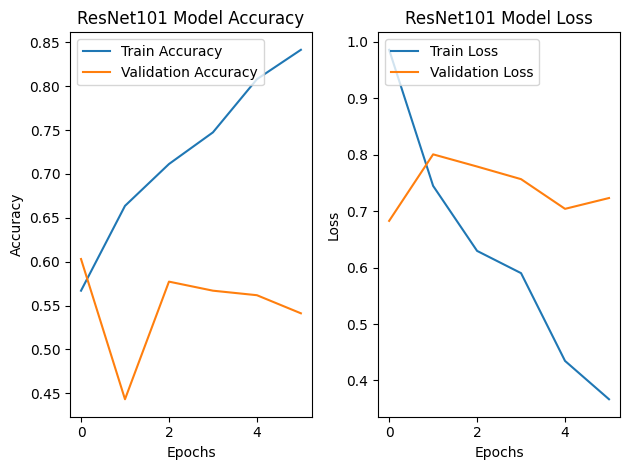

In [22]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_resnet101.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet101.history['loss'], label='Train Loss')
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


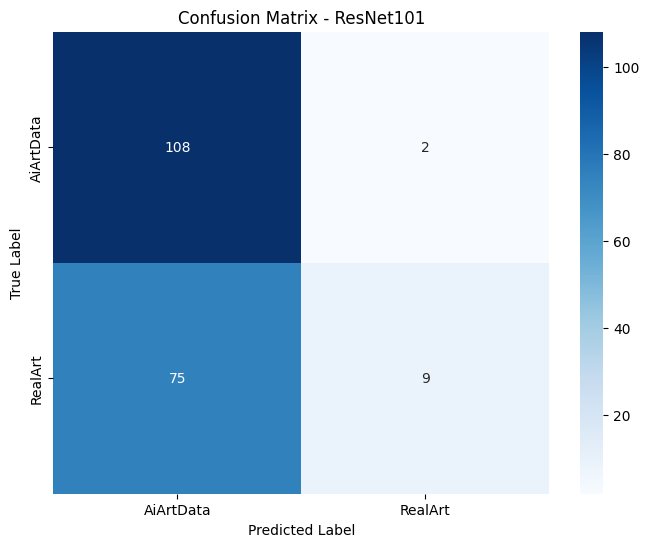

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.98      0.74       110
           1       0.82      0.11      0.19        84

    accuracy                           0.60       194
   macro avg       0.70      0.54      0.46       194
weighted avg       0.69      0.60      0.50       194



In [23]:
# Confusion Matrix and Classification Report
# Generate predictions
Y_pred = resnet101_model.predict(testing_image_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = testing_image_generator.classes

# Generate confusion matrix
conf_matrix_resnet101 = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resnet101, annot=True, fmt='d', cmap='Blues',
            xticklabels=testing_image_generator.class_indices.keys(),
            yticklabels=testing_image_generator.class_indices.keys())
plt.title('Confusion Matrix - ResNet101')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)